In [1]:
# theta-only-test.ipynb

# in this notebook we look at modelling the waveform at a single value
# of time to speed up testing of fitting the other physical parameters
#
# i think i can do this because RFF seems to work so well
# that once the 'theta' parameters can be fit well all you
# need to do is add O(1000) times more data for the times.

In [ ]:
# including inclination and coa_phase cause the
# the loss to not decrease because edge on cases are difficult
# to model but also less important in terms of amplitude

# can I write a custom metric that computes a quantity like amplitude weighted mse?
# so that edge-on cases are down-weighted?

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [3]:
import datetime
import os
import numpy as np
import math

import waveform
import sample
import model_utils
import dataset

2022-07-10 02:15:28.543737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 02:15:28.543795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import wispy.callbacks

In [5]:
# from model_utils import PoisonPillCallback

In [6]:
import pandas as pd

In [7]:
import tensorflow as tf

In [8]:
import pycbc.pnutils

In [9]:
import lalsimulation as lalsim

In [422]:
import sklearn.preprocessing

In [10]:
plt.rcParams.update({'font.size':16})

# generate waveform data

In [387]:
def gen_waveform_set(train_test_val, n_samples, t_index, nproc=1, mass_ratio_low=1, mass_ratio_high=8, return_data='hp_hc'):
    assert train_test_val in ['train', 'val']
    
    # approximant="IMRPhenomXHM"
    # approximant="IMRPhenomXPHM"
    # approximant="SEOBNRv4PHM"
    # approximant="IMRPhenomXAS"
    # approximant="SEOBNRv4_opt"
    # approximant="SEOBNRv4P"
    # approximant="SEOBNRv4P"
    approximant="IMRPhenomXP"
    # approximant="IMRPhenomD"
    # approximant="IMRPhenomHM"

    # uniform spacing throughout
    t1 = -2000
    # t1 = -500
    # t1 = -200
    # t1 = -50
    
    # t1 = -50
    t2 = 70
    # t1 = -10
    # t2 = 20
    dt = 0.25
    new_times_M = np.arange(t1, t2, dt)

    t_idxs = np.arange(len(new_times_M))
    # t_training_idxs = None
    # t_validation_idxs = None
    if train_test_val == "train":
        t_idxs_sample = t_idxs[::2]
    elif train_test_val == "val":
        # t_idxs_sample = t_idxs[1::2]
        t_idxs_sample = t_idxs[::2]

    total_mass=100
    distance_mpc=1
    delta_t=1/4096
    f_lower=10
    
    # out = sample.draw_mass_ratio_inc_coa_phase_samples(n_samples, mass_ratio_low, mass_ratio_high)
    # out = sample.draw_inc_coa_phase_samples(n_samples, mass_ratio=1)
    out = sample.draw_9d_samples(n_samples, mass_ratio_low=1, mass_ratio_high=2)
    # out = sample.draw_mass_ratio_samples(n_samples, mass_ratio_low, mass_ratio_high)
    mass_ratios = out[0]
    # spin1xs = out[1]
    # spin1ys = out[2]
    spin1xs = np.zeros_like(out[1])
    spin1ys = np.zeros_like(out[2])
    # spin1zs = out[3]
    spin1zs = np.zeros_like(out[3])
    # spin2xs = out[4]
    # spin2ys = out[5]
    spin2xs = np.zeros_like(out[4])
    spin2ys = np.zeros_like(out[5])
    # spin2zs = out[6]
    spin2zs = np.zeros_like(out[6])
    coa_phases = out[7]
    # coa_phases = np.zeros_like(out[7])
    inclinations = out[8]
    # inclinations = np.zeros_like(out[8])
    # inclinations = np.zeros_like(out[8]) + np.pi/2.1
    # inclinations = np.zeros_like(out[8]) + np.pi/1.9
    # inclinations = np.zeros_like(out[8]) + (5 * 180/np.pi)
    
    # mass_ratios = np.zeros(n_samples) + 4
    # # spin1xs = np.random.uniform(0, 0.99, n_samples)
    # spin1xs = np.zeros(n_samples) + 0.99
    # spin1ys = np.zeros(n_samples)
    # spin1zs = np.zeros(n_samples)
    # spin2xs = np.zeros(n_samples)
    # spin2ys = np.zeros(n_samples)
    # spin2zs = np.zeros(n_samples)
    # coa_phases = np.zeros(n_samples)
    # # inclinations = np.zeros(n_samples)
    # inclinations = np.random.uniform(0, np.pi, n_samples)
    

    starttime = datetime.datetime.now()

    times, thetas, hps, hcs = waveform.generate_waveforms_mp(
        new_times_M,
        mass_ratios,
        spin1xs,
        spin1ys,
        spin1zs,
        spin2xs,
        spin2ys,
        spin2zs,
        coa_phases,
        inclinations,
        time_idxs=t_idxs_sample,
        total_mass=total_mass,
        approximant=approximant,
        distance_mpc=distance_mpc,
        delta_t=delta_t,
        f_lower=f_lower,
        nproc=nproc,
        return_data=return_data,
    )

    endtime = datetime.datetime.now()
    duration = endtime - starttime
    print(f"The time cost: {duration}")
    

    return times[t_index][:,np.newaxis], thetas, hps[:,t_index][:,np.newaxis], hcs[:,t_index][:,np.newaxis]

In [388]:
parameter_names = ['mass_ratio', 'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'coa_phase', 'inclination']

In [465]:
# n_samples_train=50000
# n_samples_train=8000
n_samples_train=100_000
# n_samples_train=10_000
# n_samples_train=1000
n_samples_val=100

# return_data='amp_phi'
return_data='hp_hc'

t_index = 100

In [466]:
train_times, train_thetas, train_hps, train_hcs = gen_waveform_set(t_index=t_index, train_test_val='train', n_samples=n_samples_train, nproc=20, return_data=return_data)
# train_times, train_thetas, train_hcs, train_hps = gen_waveform_set(train_test_val='train', n_samples=n_samples_train, nproc=8)

The time cost: 0:03:07.142912


In [467]:
[ii.shape for ii in [train_times, train_thetas, train_hps, train_hcs]]

[(1, 1), (100000, 9), (100000, 1), (100000, 1)]

In [468]:
# train_thetas[:,[0,7,8]]

In [469]:
val_times, val_thetas, val_hps, val_hcs = gen_waveform_set(t_index=t_index, train_test_val='val', n_samples=n_samples_val, nproc=4, return_data=return_data)
# val_times, val_thetas, val_hcs, val_hps = gen_waveform_set(train_test_val='val', n_samples=n_samples_val, nproc=4)

The time cost: 0:00:02.950946


In [470]:
[ii.shape for ii in [val_times, val_thetas, val_hps, val_hcs]]

[(1, 1), (100, 9), (100, 1), (100, 1)]

In [471]:
train_thetas

array([[1.39996172, 0.        , 0.        , ..., 0.        , 2.27357459,
        2.61324611],
       [1.89893266, 0.        , 0.        , ..., 0.        , 6.27826123,
        1.35870013],
       [1.04219369, 0.        , 0.        , ..., 0.        , 0.4831657 ,
        1.45879854],
       ...,
       [1.32531351, 0.        , 0.        , ..., 0.        , 2.01173976,
        1.92940189],
       [1.96973568, 0.        , 0.        , ..., 0.        , 5.89791468,
        0.80161611],
       [1.83272272, 0.        , 0.        , ..., 0.        , 1.56096807,
        1.84954912]])

In [472]:
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
train_hps = y_scaler.fit_transform(train_hps)
val_hps = y_scaler.transform(val_hps)

In [ ]:
# theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
# train_thetas = y_scaler.fit_transform(train_thetas)
# val_thetas = y_scaler.transform(val_thetas)

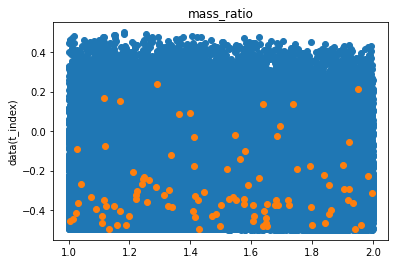

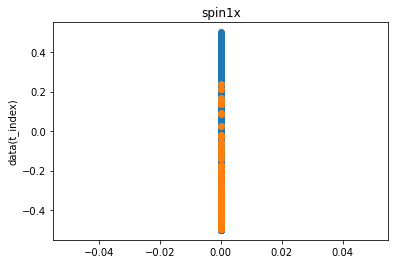

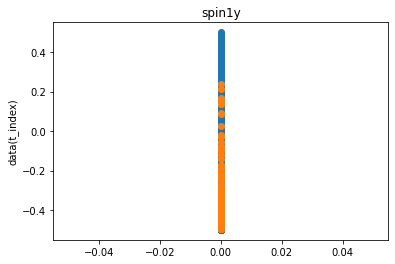

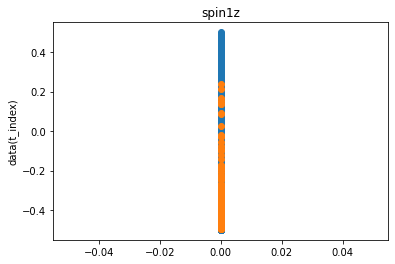

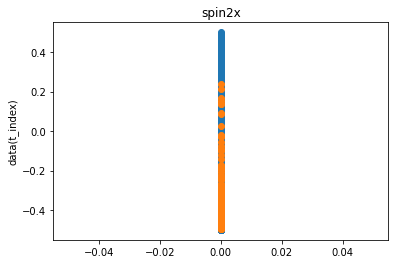

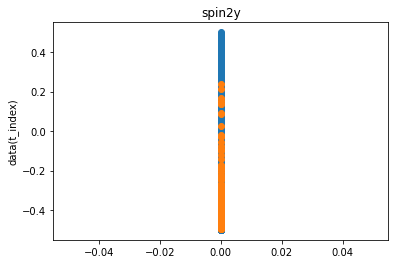

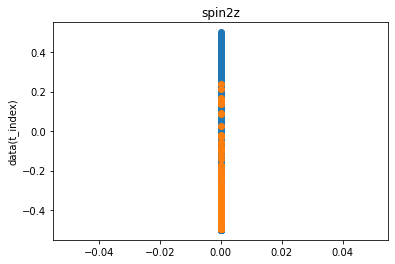

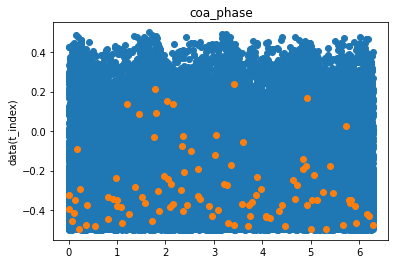

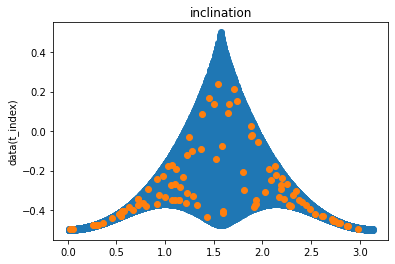

In [473]:
for i in range(train_thetas.shape[1]):
    plt.figure()
    plt.plot(train_thetas[:,i], train_hps, 'o')
    plt.plot(val_thetas[:,i], val_hps, 'o')
    plt.title(parameter_names[i])
    plt.ylabel('data(t_index)')

# setup and fit model

In [474]:
def create_model(model_type, theta_input_shape, theta_b_scale, fan_in=128, n_layers=3, units=256, activation='relu'):
    if model_type == 'rff':
        theta_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale)
        theta_bias_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.)
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x_theta = tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializer, bias_initializer=theta_bias_initializer, trainable=False)(theta_input)
        x = tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_theta)
    elif model_type == 'rff-all':
        theta_kernel_initializers = [tf.keras.initializers.RandomNormal(mean=0., stddev=theta_b_scale) for i in range(theta_input_shape)]
        theta_bias_initializers = [tf.keras.initializers.RandomUniform(minval=-1., maxval=1.) for i in range(theta_input_shape)]
        theta_inputs = [tf.keras.Input(shape=(1,), name=f'theta_input_{i}') for i in range(theta_input_shape)]
        x_thetas = []
        xs = []
        for i, theta_input in enumerate(theta_inputs):
            x_thetas.append(tf.keras.layers.Dense(fan_in, kernel_initializer=theta_kernel_initializers[i], bias_initializer=theta_bias_initializers[i], trainable=False)(theta_input))
            xs.append(tf.keras.layers.Lambda(lambda x: tf.math.sin(np.pi*x))(x_thetas[i]))
        x = tf.keras.layers.Concatenate()(xs)
    elif model_type == 'plain':
        theta_input = tf.keras.Input(shape=(theta_input_shape,), name='theta_input')
        x = tf.keras.layers.Dense(fan_in, activation=activation)(theta_input)
    
    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    if model_type == 'rff':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    elif model_type == 'rff-all':
        model = tf.keras.Model(inputs=theta_inputs, outputs=x)
    elif model_type == 'plain':
        model = tf.keras.Model(inputs=theta_input, outputs=x)
    
    # print(model.summary())

    return model

def run_model_ds(X_train, y_train, batch_size, theta_b_scale, theta_input_shape, model_type, epochs=1001, threshold=1e-7, validation_data=None, verbose=0, learning_rate=1e-3, fan_in=128, n_layers=3, units=256, activation='relu', checkpoint_filepath=None):

    assert model_type in ['rff', 'plain', 'rff-all']
    model = create_model(model_type=model_type, theta_input_shape=theta_input_shape, theta_b_scale=theta_b_scale, fan_in=fan_in, n_layers=n_layers, units=units, activation=activation)
    
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    if checkpoint_filepath is None:
        checkpoint_filepath = './checkpoint_dir_theta_only/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True)
    
    callbacks = [
        wispy.callbacks.ThresholdCallback(threshold),
        model_checkpoint_callback,
        # PoisonPillCallback(),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

    if model_type == 'rff-all':
        history = model.fit([X_train[:,0],X_train[:,1],X_train[:,2],X_train[:,3],X_train[:,4],X_train[:,5],X_train[:,6],X_train[:,7],X_train[:,8]], y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    else:
        history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data)
    
    # The model weights (that are considered the best) are loaded into the model.
    print("loading best weights from checkpoint")
    model.load_weights(checkpoint_filepath)

    return history, model

theta_input_shape: 9
making traing dataset
total_number_of_points (training): 100000
steps_per_epoch: 3125


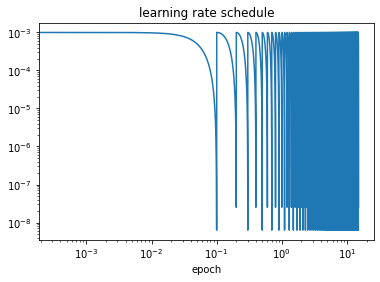

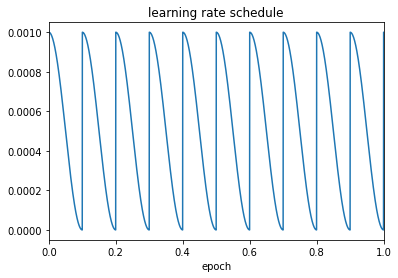

In [475]:
epochs = 15
# epochs = 30
# epochs = 100
#batch_size = 1024
# batch_size = 512
# batch_size = 128
# batch_size = 64
batch_size = 32
# batch_size = 16
# batch_size = 8

theta_input_shape = train_thetas.shape[1]
print(f"theta_input_shape: {theta_input_shape}")

print("making traing dataset")

X_train = train_thetas
y_train = train_hps






total_number_of_points = X_train.shape[0]



print(f"total_number_of_points (training): {total_number_of_points}")

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/10,
    # t_mul=2.0,
    # t_mul=1.2,
    t_mul=1.,
    m_mul=1.,
    # m_mul=0.9,
    alpha=0.0,
    name=None
)


step = np.arange(0, epochs * steps_per_epoch)
lr_ = lrs(step)

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
plt.yscale('log')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(step/steps_per_epoch, lr_)
plt.xlabel("epoch")
plt.title("learning rate schedule")
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 1)
plt.show()
plt.close()



In [476]:
%%time
# theta_b_scale=0.2
theta_b_scale=1.
validation_data=(val_thetas, val_hps)
# validation_data=([val_thetas[:,0],val_thetas[:,1],val_thetas[:,2],val_thetas[:,3],val_thetas[:,4],val_thetas[:,5],val_thetas[:,6],val_thetas[:,7],val_thetas[:,8]], val_hps)
history_rff, model_rff = run_model_ds(
    X_train,
    y_train,
    batch_size,
    theta_b_scale,
    theta_input_shape,
    # model_type='rff-all',
    model_type='rff',
    epochs=epochs,
    threshold=1e-8,
    validation_data=validation_data,
    verbose=1,
    learning_rate=lrs,
    fan_in=128,
    n_layers=6,
    units=256,
    # n_layers=12,
    # units=256,
    # n_layers=6,
    # units=512,
    activation='relu',
    checkpoint_filepath=None,
)

Epoch 1/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0028 - val_loss: 8.1063e-04
Epoch 2/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0011 - val_loss: 8.0111e-04
Epoch 3/15
3125/3125 [==============================] - 14s 5ms/step - loss: 8.6746e-04 - val_loss: 4.3829e-04
Epoch 4/15
3125/3125 [==============================] - 14s 5ms/step - loss: 6.7571e-04 - val_loss: 2.5500e-04
Epoch 5/15
3125/3125 [==============================] - 15s 5ms/step - loss: 5.9499e-04 - val_loss: 1.4733e-04
Epoch 6/15
3125/3125 [==============================] - 14s 5ms/step - loss: 6.0076e-04 - val_loss: 1.0363e-04
Epoch 7/15
3125/3125 [==============================] - 14s 5ms/step - loss: 4.5617e-04 - val_loss: 1.3147e-04
Epoch 8/15
3125/3125 [==============================] - 15s 5ms/step - loss: 5.0109e-04 - val_loss: 3.0431e-04
Epoch 9/15
3125/3125 [==============================] - 14s 5ms/step - loss: 4.0876e-04 - val_loss: 9.7009e-05
Epoch 10/

In [477]:
model_rff.summary()

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 theta_input (InputLayer)    [(None, 9)]               0         
                                                                 
 dense_422 (Dense)           (None, 128)               1280      
                                                                 
 lambda_69 (Lambda)          (None, 128)               0         
                                                                 
 dense_423 (Dense)           (None, 256)               33024     
                                                                 
 dense_424 (Dense)           (None, 256)               65792     
                                                                 
 dense_425 (Dense)           (None, 256)               65792     
                                                                 
 dense_426 (Dense)           (None, 256)               657

In [478]:
# %%time
# validation_data=(val_thetas, val_hps)
# history_plain, model_plain = run_model_ds(
#     X_train,
#     y_train,
#     batch_size,
#     theta_b_scale,
#     theta_input_shape,
#     model_type='plain',
#     epochs=epochs,
#     threshold=1e-8,
#     validation_data=validation_data,
#     verbose=1,
#     learning_rate=lrs,
#     fan_in=128,
#     # n_layers=3,
#     n_layers=6,
#     units=256,
#     # n_layers=12,
#     # units=256,
#     activation='relu',
#     checkpoint_filepath=None,
# )

Epoch 1/15
3125/3125 [==============================] - 16s 5ms/step - loss: 0.0213 - val_loss: 0.0144
Epoch 2/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0202 - val_loss: 0.0173
Epoch 3/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0173 - val_loss: 0.0100
Epoch 4/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0130 - val_loss: 0.0072
Epoch 5/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 6/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 7/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 8/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 9/15
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/15
3125/3125 [==============================] - 15s 5ms/step - l

In [479]:
model_plain.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 theta_input (InputLayer)    [(None, 9)]               0         
                                                                 
 dense_430 (Dense)           (None, 128)               1280      
                                                                 
 dense_431 (Dense)           (None, 256)               33024     
                                                                 
 dense_432 (Dense)           (None, 256)               65792     
                                                                 
 dense_433 (Dense)           (None, 256)               65792     
                                                                 
 dense_434 (Dense)           (None, 256)               65792     
                                                                 
 dense_435 (Dense)           (None, 256)               657

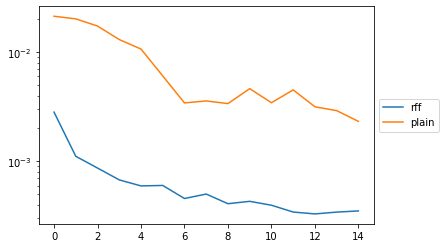

In [480]:
plt.figure()
plt.plot(history_rff.history['loss'], label='rff')
plt.plot(history_plain.history['loss'], label='plain')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

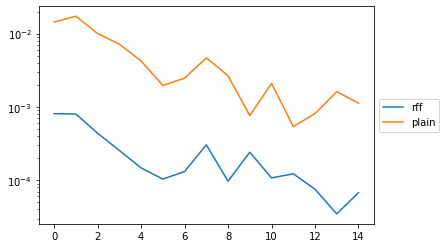

In [481]:
plt.figure()
plt.plot(history_rff.history['val_loss'], label='rff')
plt.plot(history_plain.history['val_loss'], label='plain')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [482]:
yhat_train_rff = model_rff(train_thetas)
yhat_train_plain = model_plain(train_thetas)

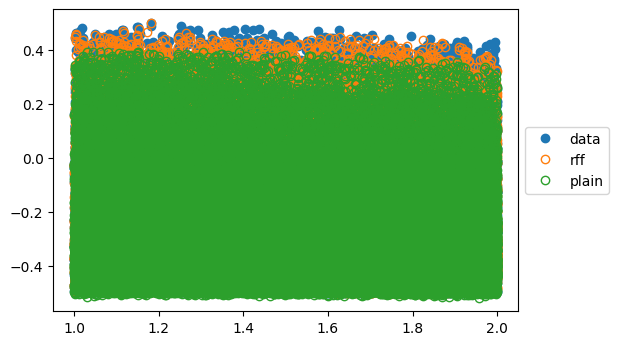

In [483]:
plt.figure(dpi=100)
plt.plot(train_thetas[:,0], y_train, 'o', label='data')
plt.plot(train_thetas[:,0], yhat_train_rff, 'o', label='rff', mfc='none')
plt.plot(train_thetas[:,0], yhat_train_plain, 'o', label='plain', mfc='none')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

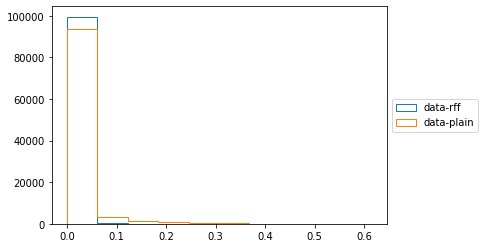

In [484]:
plt.figure()
plt.hist(np.abs(y_train-yhat_train_rff), histtype='step', label='data-rff')
plt.hist(np.abs(y_train-yhat_train_plain), histtype='step', label='data-plain');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

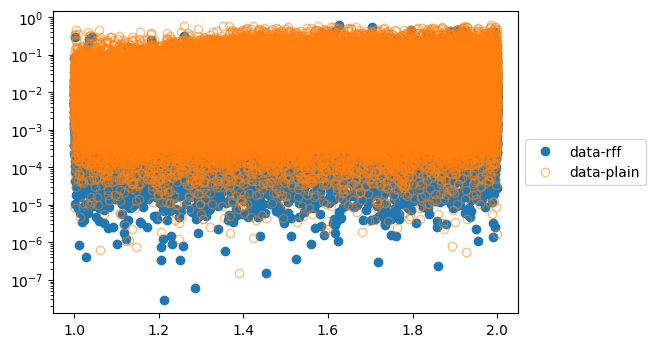

In [485]:
plt.figure(dpi=100)
plt.plot(train_thetas[:,0], np.abs(y_train-yhat_train_rff), 'o', label='data-rff')
plt.plot(train_thetas[:,0], np.abs(y_train-yhat_train_plain), 'o', label='data-plain', alpha=0.5, mfc='none')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

In [486]:
yhat_rff = model_rff(val_thetas)
yhat_plain = model_plain(val_thetas)

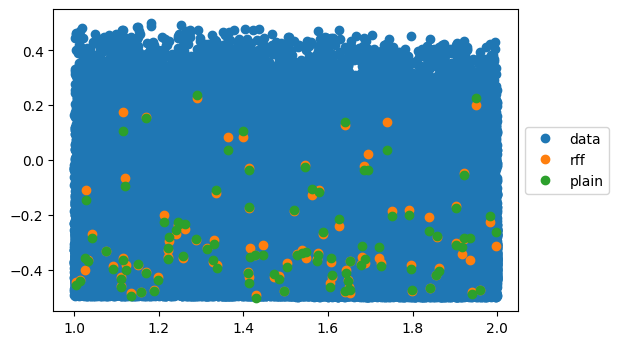

In [487]:
plt.figure(dpi=100)
plt.plot(X_train[:,0], y_train, 'o', label='data')
plt.plot(val_thetas[:,0], yhat_rff, 'o', label='rff')
plt.plot(val_thetas[:,0], yhat_plain, 'o', label='plain')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

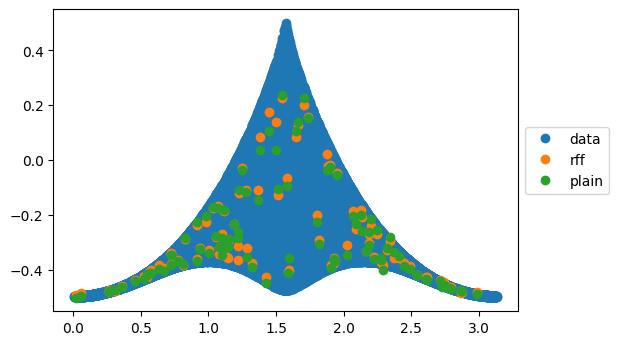

In [488]:
plt.figure(dpi=100)
plt.plot(X_train[:,8], y_train, 'o', label='data')
plt.plot(val_thetas[:,8], yhat_rff, 'o', label='rff')
plt.plot(val_thetas[:,8], yhat_plain, 'o', label='plain')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

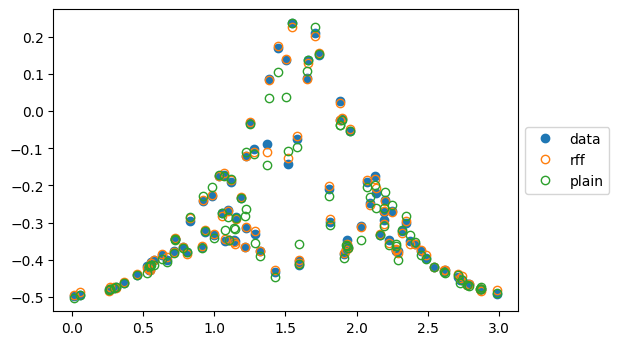

In [489]:
plt.figure(dpi=100)
plt.plot(val_thetas[:,8], val_hps, 'o', label='data')
plt.plot(val_thetas[:,8], yhat_rff, 'o', label='rff', mfc='none')
plt.plot(val_thetas[:,8], yhat_plain, 'o', label='plain', mfc='none')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

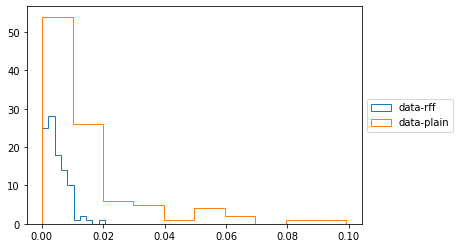

In [490]:
plt.figure()
plt.hist(np.abs(val_hps-yhat_rff), histtype='step', label='data-rff')
plt.hist(np.abs(val_hps-yhat_plain), histtype='step', label='data-plain');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))